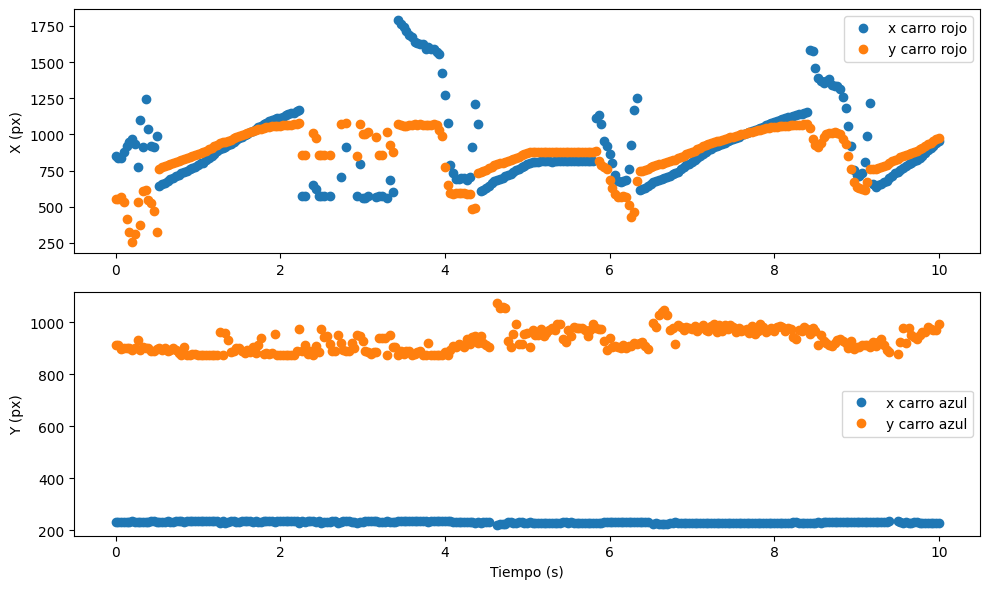

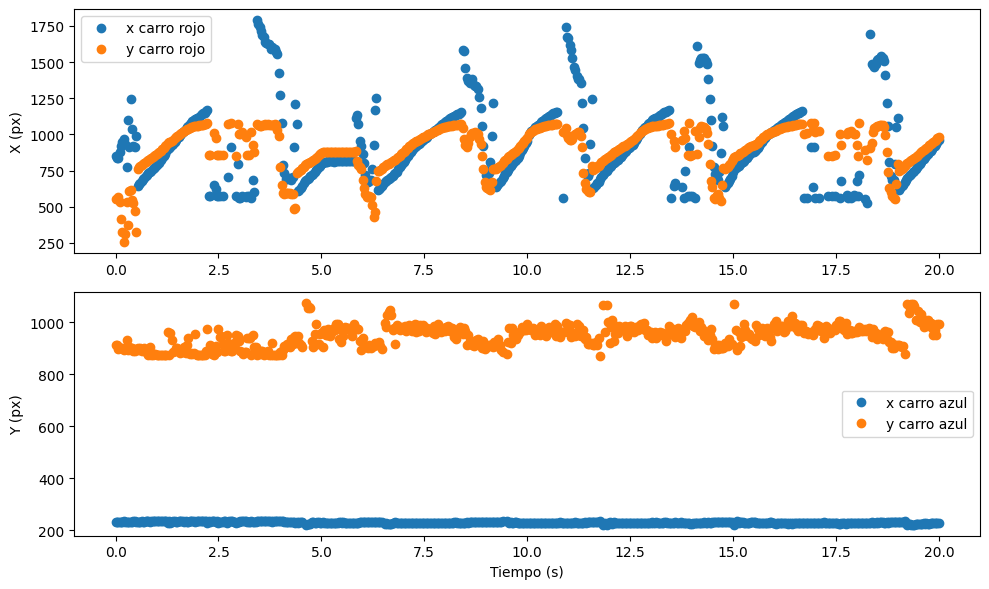

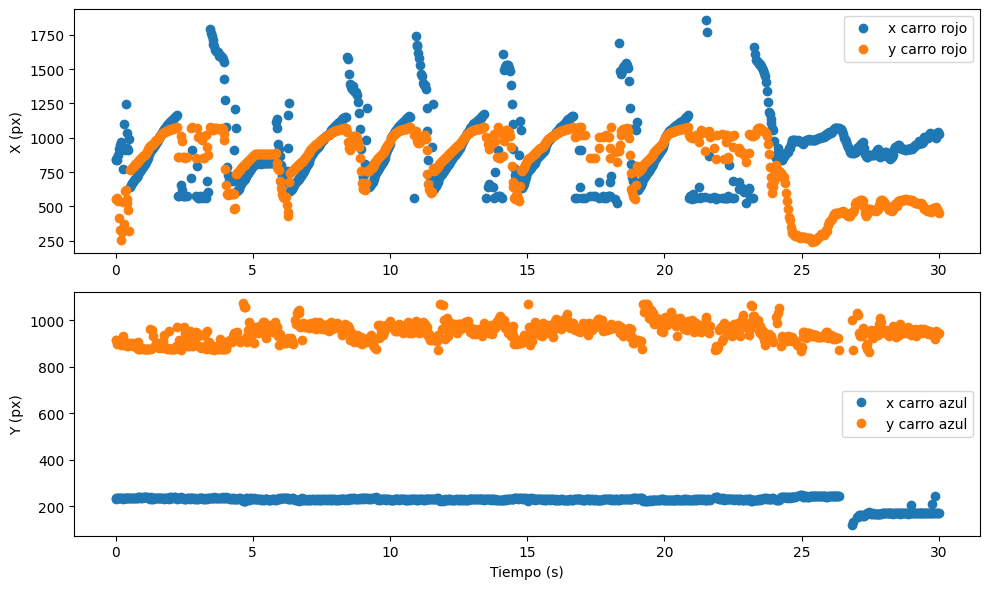

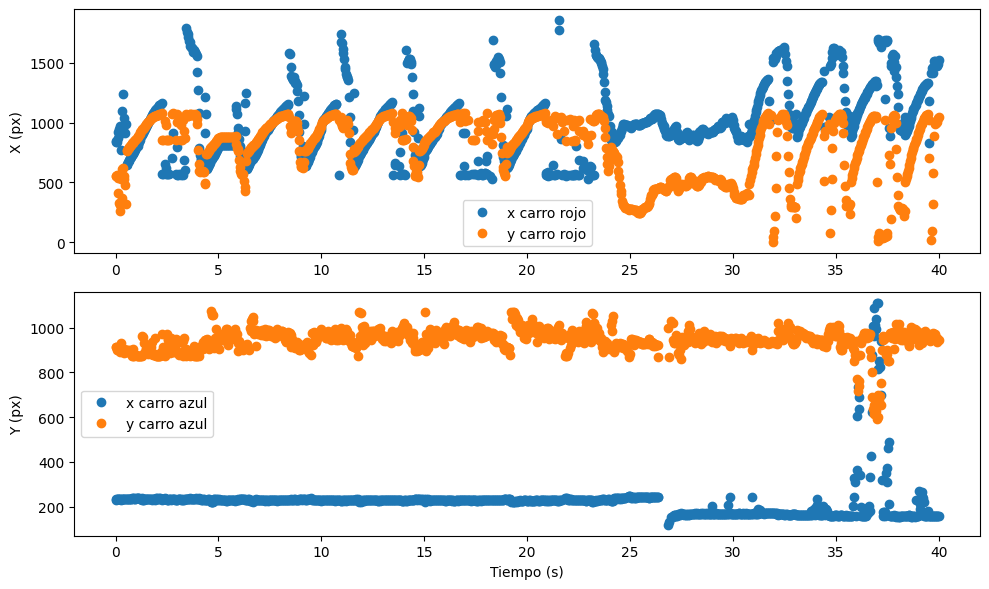

KeyboardInterrupt: 

: 

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from time import time, strftime, localtime

# Crear carpeta del experimento
timestamp_str = strftime("experimento_%Y%m%d_%H%M%S", localtime())
os.makedirs(timestamp_str, exist_ok=True)

# Inicializar cámara
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("No se pudo acceder a la cámara")

# Propiedades de video
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = 30
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Guardar videos
out_original = cv2.VideoWriter(f"{timestamp_str}/video_original.avi", fourcc, fps, (width, height))
out_clean = cv2.VideoWriter(f"{timestamp_str}/video_sin_puntos.avi", fourcc, fps, (width, height))

# Ventana única
cv2.namedWindow("Camara", cv2.WINDOW_NORMAL)

# Variables
datos = []
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    timestamp = frame_count / fps
    frame_clean = frame.copy()  # Copia antes de dibujar puntos
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # --- Filtro rojo (dos rangos) ---
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([180, 255, 255])
    mask_red = cv2.inRange(hsv, lower_red1, upper_red1) | cv2.inRange(hsv, lower_red2, upper_red2)

    # --- Filtro azul (azul oscuro) ---
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([130, 255, 255])
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

    # --- Centro de masa rojo ---
    M_red = cv2.moments(mask_red)
    if M_red["m00"] != 0:
        cx_red = int(M_red["m10"] / M_red["m00"])
        cy_red = int(M_red["m01"] / M_red["m00"])
        cv2.circle(frame, (cx_red, cy_red), 5, (0, 0, 255), -1)
    else:
        cx_red, cy_red = np.nan, np.nan

    # --- Centro de masa azul ---
    M_blue = cv2.moments(mask_blue)
    if M_blue["m00"] != 0:
        cx_blue = int(M_blue["m10"] / M_blue["m00"])
        cy_blue = int(M_blue["m01"] / M_blue["m00"])
        cv2.circle(frame, (cx_blue, cy_blue), 5, (255, 0, 0), -1)
    else:
        cx_blue, cy_blue = np.nan, np.nan

    # Guardar datos
    datos.append([timestamp, cx_red, cy_red, cx_blue, cy_blue])

    # Mostrar cámara en tiempo real
    cv2.imshow("Camara", frame)

    # Escribir videos
    out_original.write(frame)
    out_clean.write(frame_clean)

    # Mostrar gráfico cada 10 s
    if int(timestamp) % 10 == 0 and frame_count != 0 and frame_count % (10 * fps) == 0:
        df = pd.DataFrame(datos, columns=["tiempo_s", "x_rojo", "y_rojo", "x_azul", "y_azul"])
        plt.figure(figsize=(10, 6))
        plt.subplot(2, 1, 1)
        plt.plot(df["tiempo_s"], df["x_rojo"], 'o', label="x carro rojo")
        plt.plot(df["tiempo_s"], df["y_rojo"], 'o', label="y carro rojo")
        plt.ylabel("X (px)")
        plt.legend()
        plt.subplot(2, 1, 2)
        plt.plot(df["tiempo_s"], df["x_azul"], 'o', label="x carro azul")
        plt.plot(df["tiempo_s"], df["y_azul"], 'o', label="y carro azul")
        plt.ylabel("Y (px)")
        plt.xlabel("Tiempo (s)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    frame_count += 1

    # Salir con 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Guardar CSV
df_final = pd.DataFrame(datos, columns=["tiempo_s", "x_rojo", "y_rojo", "x_azul", "y_azul"])
df_final.to_csv(f"{timestamp_str}/trayectorias.csv", index=False)

# Liberar recursos
cap.release()
out_original.release()
out_clean.release()
cv2.destroyAllWindows()
print(f"✅ Datos y videos guardados en: {timestamp_str}")